In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 3s 0us/step


In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [4]:
def create_model():
    input_layer = Input(shape=(28, 28, 1))
    x = Flatten()(input_layer)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(10, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=x)
    return model

model = create_model()


In [5]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [6]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=128)


Epoch 1/10
469/469 [==============================] - 1s 2ms/step - loss: 0.4044 - accuracy: 0.8834 - val_loss: 0.1962 - val_accuracy: 0.9425
Epoch 2/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1952 - accuracy: 0.9430 - val_loss: 0.1353 - val_accuracy: 0.9604
Epoch 3/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1464 - accuracy: 0.9578 - val_loss: 0.1105 - val_accuracy: 0.9662
Epoch 4/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1180 - accuracy: 0.9645 - val_loss: 0.0936 - val_accuracy: 0.9719
Epoch 5/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1006 - accuracy: 0.9706 - val_loss: 0.0896 - val_accuracy: 0.9728
Epoch 6/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0850 - accuracy: 0.9741 - val_loss: 0.0837 - val_accuracy: 0.9746
Epoch 7/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0773 - accuracy: 0.9764 - val_loss: 0.0781 - val_accuracy: 0.9754
Epoch 

In [19]:
def generate_adversarial_example(model, image, label, epsilon=0.1):
    # 입력 이미지를 모델에 넣어서 예측합니다.
    image = np.expand_dims(image, axis=0)
    pred = model.predict(image)
    pred_label = np.argmax(pred, axis=1)[0]

    # 예측한 라벨이 타겟 라벨과 같으면 이미 정답입니다.
    if pred_label == label:
        return image[0]

    # 적대적인 이미지를 생성합니다.
    adv_image = image
    adv_label = pred_label
    while adv_label != label:
        # 입력 이미지와 적대적인 이미지의 차이를 계산합니다.
        delta = K.sign(K.gradients(model.output, model.input)[0])
        sess = K.get_session()
        adv_image = adv_image + epsilon * sess.run(delta, feed_dict={model.input: adv_image})
        adv_image = np.clip(adv_image, 0, 1)

        # 적대적인 이미지를 모델에 넣어서 예측합니다.
        pred = model.predict(adv_image)
        adv_label = np.argmax(pred, axis=1)[0]

    return adv_image[0]

In [20]:
# 정확도를 측정하는 함수
def accuracy(model, x, y):
    y_pred = model.predict(x)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y, axis=1)
    acc = np.mean(y_pred == y_true)
    return acc

# 테스트 데이터 중 10개의 이미지를 선택하여 적대적인 예제를 생성하고 결과를 비교해봅니다.
indices = np.random.choice(x_test.shape[0], size=10)
for index in indices:
    image = x_test[index]
    label = y_test[index]
    adv_image = generate_adversarial_example(model, image, label, epsilon=0.1)

    # 원래의 이미지와 적대적인 예제를 시각화합니다.
    import matplotlib.pyplot as plt
    plt.subplot(1, 3, 1)
    plt.imshow(image[:, :, 0], cmap='gray')
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(adv_image[:, :, 0], cmap='gray')
    plt.title('Adversarial example')
    plt.axis('off')

    # 원래의 이미지와 적대적인 예제를 모델에 입력하여 예측합니다.
    image = np.expand_dims(image, axis=0)
    adv_image = np.expand_dims(adv_image, axis=0)
    pred_image = model.predict(image)
    pred_adv_image = model.predict(adv_image)

    # 예측 결과를 출력합니다.
    plt.subplot(1, 3, 3)
    plt.bar(range(10), pred_image[0])
    plt.title('Original prediction')
    plt.ylim([0, 1])
    plt.xticks(range(10))
    plt.subplot(1, 3, 1)  # 수정
    plt.bar(range(10), pred_adv_image[0])
    plt.title('Adversarial prediction')
    plt.ylim([0, 1])
    plt.xticks(range(10))
    plt.show()

    # 정확도를 출력합니다.
    acc = accuracy(model, np.expand_dims(x_test[index], axis=0), np.expand_dims(y_test[index], axis=0))
    print('Accuracy on original image: {:.2f}%'.format(acc * 100))
    acc = accuracy(model, np.expand_dims(adv_image, axis=0), np.expand_dims(y_test[index], axis=0))
    print('Accuracy on adversarial image: {:.2f}%'.format(acc * 100))

1/1 [==============================] - 0s 54ms/step


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [21]:
def generate_adversarial_example(model, image, label, epsilon):
    """
    주어진 모델, 이미지, 라벨, 입실론 값을 이용하여 적대적인 예제를 생성합니다.
    """
    # 이미지와 라벨을 텐서로 변환합니다.
    image = tf.convert_to_tensor(image[np.newaxis, ...], dtype=tf.float32)
    label = tf.convert_to_tensor(label[np.newaxis, ...], dtype=tf.float32)
    # 적대적인 예제를 생성합니다.
    with tf.GradientTape() as tape:
        tape.watch(image)
        pred = model(image)
        loss = tf.keras.losses.CategoricalCrossentropy()(label, pred)
    grad = tape.gradient(loss, image)
    signed_grad = tf.sign(grad)
    adv_image = image + epsilon * signed_grad
    adv_image = tf.clip_by_value(adv_image, 0, 1)
    return np.squeeze(adv_image.numpy(), axis=0)

1/1 [==============================] - 0s 12ms/step


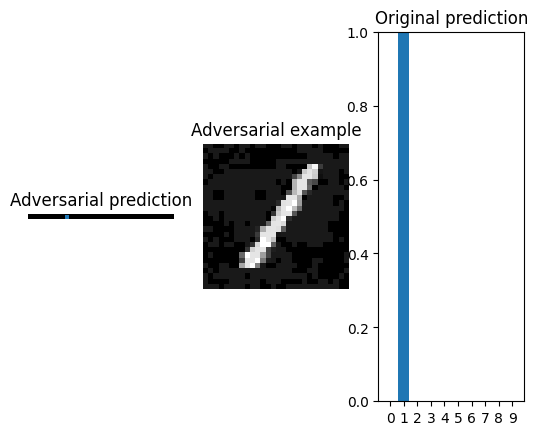

1/1 [==============================] - 0s 13ms/step
Accuracy on original image: 100.00%
1/1 [==============================] - 0s 32ms/step
Accuracy on adversarial image: 0.00%
1/1 [==============================] - 0s 12ms/step


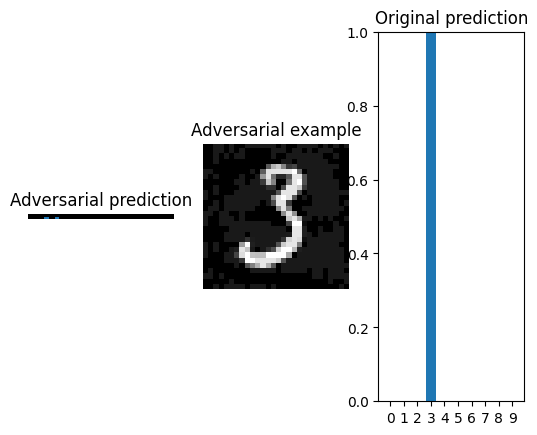

1/1 [==============================] - 0s 14ms/step
Accuracy on original image: 100.00%
1/1 [==============================] - 0s 13ms/step
Accuracy on adversarial image: 100.00%
1/1 [==============================] - 0s 14ms/step


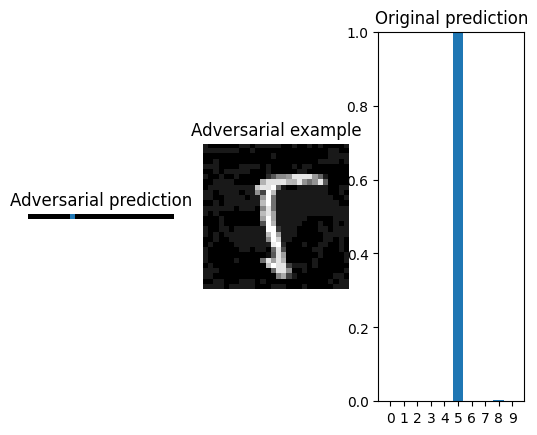

1/1 [==============================] - 0s 13ms/step
Accuracy on original image: 100.00%
1/1 [==============================] - 0s 13ms/step
Accuracy on adversarial image: 0.00%
1/1 [==============================] - 0s 13ms/step


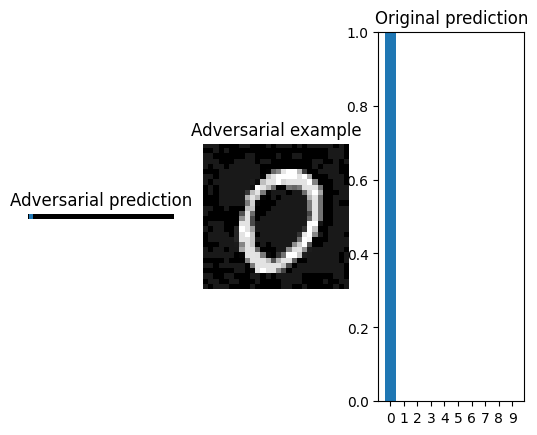

1/1 [==============================] - 0s 15ms/step
Accuracy on original image: 100.00%
1/1 [==============================] - 0s 13ms/step
Accuracy on adversarial image: 100.00%
1/1 [==============================] - 0s 13ms/step


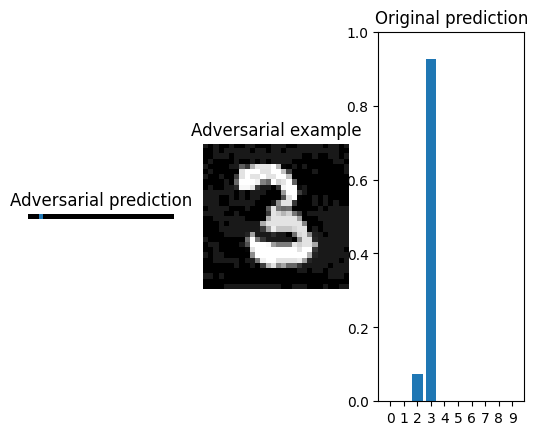

1/1 [==============================] - 0s 12ms/step
Accuracy on original image: 100.00%
1/1 [==============================] - 0s 12ms/step
Accuracy on adversarial image: 0.00%
1/1 [==============================] - 0s 13ms/step


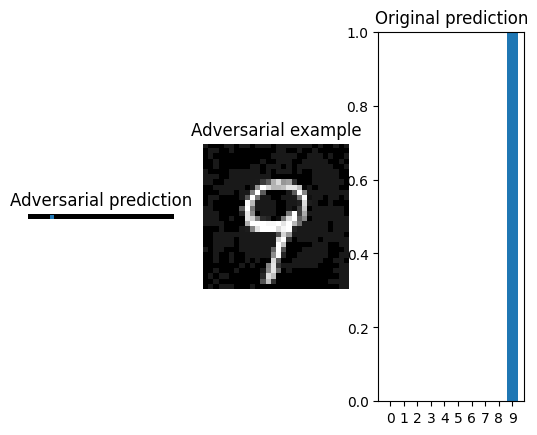

1/1 [==============================] - 0s 13ms/step
Accuracy on original image: 100.00%
1/1 [==============================] - 0s 12ms/step
Accuracy on adversarial image: 0.00%
1/1 [==============================] - 0s 15ms/step


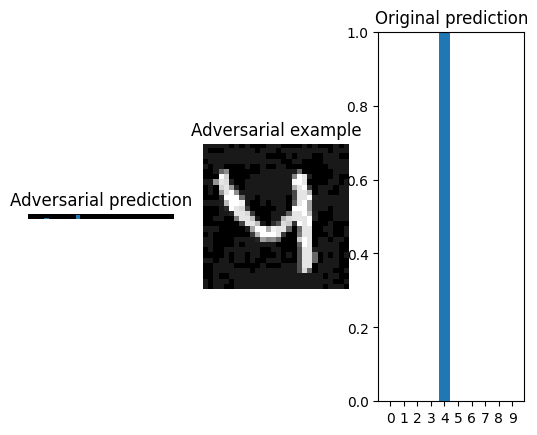

1/1 [==============================] - 0s 14ms/step
Accuracy on original image: 100.00%
1/1 [==============================] - 0s 12ms/step
Accuracy on adversarial image: 0.00%
1/1 [==============================] - 0s 12ms/step


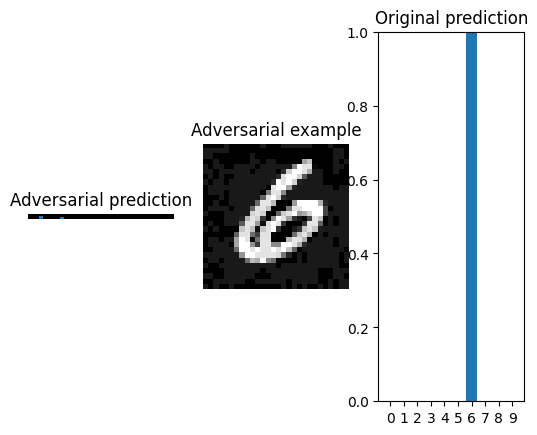

1/1 [==============================] - 0s 14ms/step
Accuracy on original image: 100.00%
1/1 [==============================] - 0s 13ms/step
Accuracy on adversarial image: 0.00%
1/1 [==============================] - 0s 13ms/step


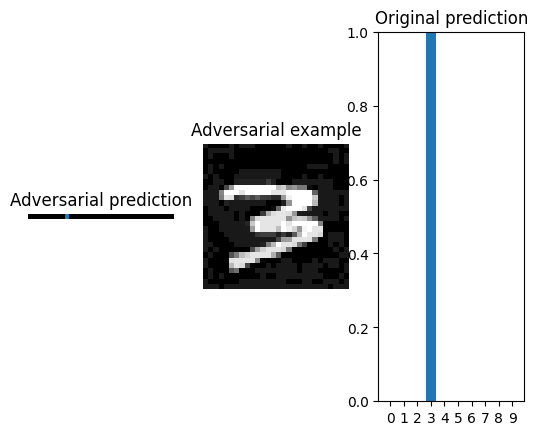

1/1 [==============================] - 0s 15ms/step
Accuracy on original image: 100.00%
1/1 [==============================] - 0s 13ms/step
Accuracy on adversarial image: 0.00%
1/1 [==============================] - 0s 12ms/step


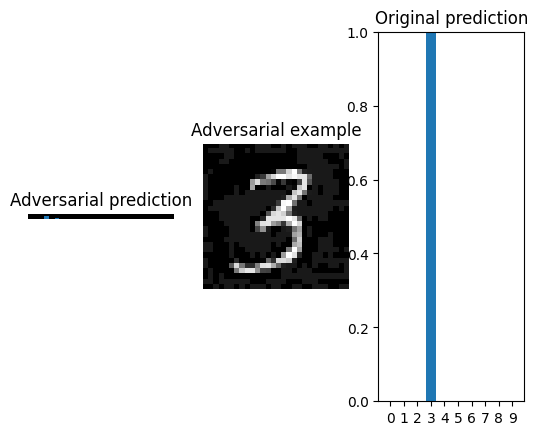

1/1 [==============================] - 0s 12ms/step
Accuracy on original image: 100.00%
1/1 [==============================] - 0s 13ms/step
Accuracy on adversarial image: 100.00%


In [22]:
indices = np.random.choice(x_test.shape[0], size=10)
for index in indices:
    image = x_test[index]
    label = y_test[index]
    adv_image = generate_adversarial_example(model, image, label, epsilon=0.1)

    # 원래의 이미지와 적대적인 예제를 시각화합니다.
    import matplotlib.pyplot as plt
    plt.subplot(1, 3, 1)
    plt.imshow(image[:, :, 0], cmap='gray')
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(adv_image[:, :, 0], cmap='gray')
    plt.title('Adversarial example')
    plt.axis('off')

    # 원래의 이미지와 적대적인 예제를 모델에 입력하여 예측합니다.
    image = np.expand_dims(image, axis=0)
    adv_image = np.expand_dims(adv_image, axis=0)
    pred_image = model.predict(image)
    pred_adv_image = model.predict(adv_image)

    # 예측 결과를 출력합니다.
    plt.subplot(1, 3, 3)
    plt.bar(range(10), pred_image[0])
    plt.title('Original prediction')
    plt.ylim([0, 1])
    plt.xticks(range(10))
    plt.subplot(1, 3, 1)  # 수정
    plt.bar(range(10), pred_adv_image[0])
    plt.title('Adversarial prediction')
    plt.ylim([0, 1])
    plt.xticks(range(10))
    plt.show()
    
    # 정확도를 출력합니다.
    acc = accuracy(model, np.expand_dims(x_test[index], axis=0), np.expand_dims(y_test[index], axis=0))
    print('Accuracy on original image: {:.2f}%'.format(acc * 100))
    acc = accuracy(model, np.expand_dims(adv_image, axis=0), np.expand_dims(y_test[index], axis=0))
    print('Accuracy on adversarial image: {:.2f}%'.format(acc * 100))